**Udemy 5-9. CNN for Fashion MNIST**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# Loading train-data using torch-vision
train_dataset = torchvision.datasets.FashionMNIST(
    root = ".",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
print(train_dataset.data.shape)
print(train_dataset.data.max())

torch.Size([60000, 28, 28])
tensor(255, dtype=torch.uint8)


In [ ]:
print(train_dataset.targets)

tensor([9, 0, 0,  ..., 3, 0, 5])


In [ ]:
# Loading the test-dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [ ]:
print(test_dataset.data.shape) # the same as original MNIST
print(test_dataset.data.max())

torch.Size([10000, 28, 28])
tensor(255, dtype=torch.uint8)


In [ ]:
print(test_dataset.targets)

tensor([9, 2, 1,  ..., 8, 1, 5])


In [ ]:
# Number of classes
K = len(set(train_dataset.targets.numpy()))
print("Number of classes:", K)

Number of classes: 10


In [ ]:
# CNN Arithmetic

**CNN Arithmetic**

$
H_{out}=
⌊{(H_{in} + 2 × P - D × (K - 1) - 1)/S + 1}⌋
$

D: Dilation

P: Padding

K: Kernel size

S: Stride

`H_out = np.floor((H_in + 2 * padding - dilation*(kernel_size - 1)-1)/stride +1)`

In [ ]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2), # 28 -> 13
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2), # 13 -> 6
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2), # 6 -> 2
        nn.ReLU(),
    )
    
    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128 * 2 * 2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512,K),
    )

  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0),-1) # out.size(0) is batch-size
    out = self.dense_layers(out)
    return out


In [ ]:
# Instantiate the CNN class
model = CNN(K)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Data Loader
# Useful because it automatically generates batches in the training loop and take care of shuffling.
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    )
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    )

In [ ]:
# Train the Model
def full_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  
  #Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    
    t0 = datetime.now()
    train_loss = []

    for inputs, targets in train_loader:
      # Move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # Zeros the parameters
      optimizer.zero_grad()

      # Forward Pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and Optimize
      loss.backward()
      optimizer.step()
      
      train_loss.append(loss.item())

    # Get train-loss and test-loss
    train_loss = np.mean(train_loss) # A little misleading

    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, duration: {dt}')
  return train_losses, test_losses


In [ ]:
train_losses, test_losses = full_gd(model, criterion, optimizer,train_loader, test_loader, epochs=15)

Epoch 1/15, train_loss: 0.1637, test_loss: 0.3172, duration: 0:00:17.710281
Epoch 2/15, train_loss: 0.1544, test_loss: 0.3492, duration: 0:00:14.914524
Epoch 3/15, train_loss: 0.1443, test_loss: 0.3461, duration: 0:00:15.522600
Epoch 4/15, train_loss: 0.1383, test_loss: 0.3435, duration: 0:00:16.589052
Epoch 5/15, train_loss: 0.1308, test_loss: 0.3576, duration: 0:00:15.170033
Epoch 6/15, train_loss: 0.1235, test_loss: 0.3519, duration: 0:00:15.166465
Epoch 7/15, train_loss: 0.1209, test_loss: 0.3765, duration: 0:00:16.205784
Epoch 8/15, train_loss: 0.1136, test_loss: 0.3706, duration: 0:00:13.599052
Epoch 9/15, train_loss: 0.1090, test_loss: 0.3741, duration: 0:00:15.529859
Epoch 10/15, train_loss: 0.1004, test_loss: 0.3812, duration: 0:00:18.723169
Epoch 11/15, train_loss: 0.0979, test_loss: 0.3868, duration: 0:00:16.605327
Epoch 12/15, train_loss: 0.0948, test_loss: 0.4134, duration: 0:00:14.517727
Epoch 13/15, train_loss: 0.0916, test_loss: 0.4320, duration: 0:00:15.316666
Epoch 14

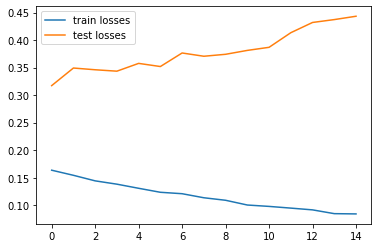

In [ ]:
plt.plot(train_losses, label="train losses")
plt.plot(test_losses, label="test losses")
plt.legend()
plt.show()

In [ ]:
# Accuracy
n_correct = 0
n_total = 0
for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs,1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total


# test accuracy
n_correct = 0
n_total = 0
for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs,1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")


Train acc: 0.9698, Test acc: 0.8925


In [ ]:
#plot Confusion Matrix 
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='confusion_matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'
  """

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion Matrix without Normalization")
  
  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             ha='center', # horizontalalignment
             va='center', # verticalalignment
             color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()


Confusion Matrix without Normalization
[[844   4  21  19   2   0 101   0   9   0]
 [  2 980   0  10   4   0   2   0   2   0]
 [ 19   0 859   8  73   0  40   0   1   0]
 [ 15  12  21 875  52   0  23   0   2   0]
 [  0   1  50  19 876   0  54   0   0   0]
 [  0   1   0   1   0 965   0  17   6  10]
 [120   0  83  27 138   1 619   0  12   0]
 [  0   0   0   0   0  11   0 962   1  26]
 [  6   1   7   3   3   4   6   4 966   0]
 [  1   0   0   0   0   6   0  38   1 954]]


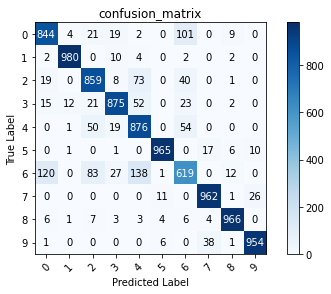

In [ ]:
# Get all predictions in an array and plot confusion matrix
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
  # Move data to GPU
  inputs = inputs.to(device)

  # Forward Pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # Update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
# Label mapping
labels = """T-shirt/Top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle Boot""".split("\n")

Text(0.5, 1.0, 'True label: Shirt - Predicted: Pullover')

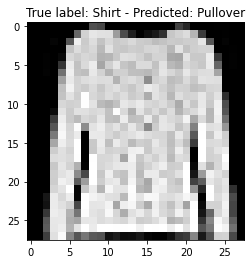

In [ ]:
# Show Some misclassified example
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap="gray")
plt.title(f"True label: {labels[y_test[i]]} - Predicted: {labels[p_test[i]]}")